In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import copy

### 阈值分割

Otsu算法

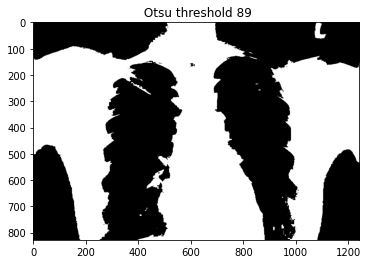

In [17]:
def cal_gray_hist(img):
    r'''计算图像的灰度值'''
    rows,cols = img.shape[:2]
    gray_hist = np.zeros([256],np.uint64)
    for i in range(rows):
        for j in range(cols):
            gray_hist[img[i][j]] +=1
    return gray_hist
def Otsu_threshold(img):
    rows,cols = img.shape[:2]
    # 计算图像的灰度直方图
    gray_img = cal_gray_hist(img)
    # 归一化直方图
    norm_gray = gray_img/float(rows*cols)
    # 计算零阶累积矩和一阶累积矩
    zero_cumu_moment = np.zeros([256],np.float32)
    one_cumu_moment = np.zeros([256],np.float32)
    for i in range(256):
        if i == 0:
            zero_cumu_moment[i] =norm_gray[i]
            one_cumu_moment[i] = 0
        else:
            zero_cumu_moment[i] = zero_cumu_moment[i-1]+norm_gray[i]
            one_cumu_moment[i] = one_cumu_moment[i-1]+i*norm_gray[i]
    # 计算方差，找到最大的方差对应的阈值
    mean = one_cumu_moment[255]
    thresh = 0
    sigma = 0
    for i in range(256):
        if zero_cumu_moment[i] == 0 or zero_cumu_moment[i] == 1:
            sigma_tmp = 0
        else:
            sigma_tmp = math.pow(mean*zero_cumu_moment[i] - one_cumu_moment[i], 2) / (zero_cumu_moment[i] * (1.0-zero_cumu_moment[i]))
        if sigma < sigma_tmp:
            thresh = i
            sigma = sigma_tmp
    # 阈值分割
    thresh_img = img.copy()
    thresh_img[thresh_img>thresh] = 255
    thresh_img[thresh_img<=thresh] = 0
    return thresh, thresh_img

thresh,img_otsu= Otsu_threshold(cv2.imread('./x.jpg'))  
plt.title(' Otsu threshold {}'.format(thresh))
plt.imshow(img_otsu)

### HSV分割


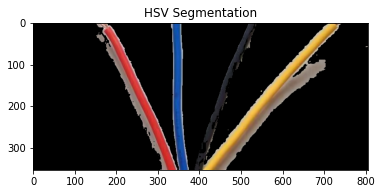

In [16]:
def hsv(img,title):
    img_line_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    # 逐通道读取
    h = img_line_hsv[:,:,0].ravel()
    # plt.hist(h,180,[0,180])
    # plt.show()

    # 生成 mask 掩模
    # hsv对应的值通过cv2窗口调动滑动条来获取值逐步设置找到
    lower = np.array([0,24,0])
    upper = np.array([179,250,255])
    # 提高上下限提取范围内的掩模 mask
    mask = cv2.inRange(img_line_hsv,lower,upper)

    # 腐蚀和膨胀处理
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3)) # 定义结构元素的形状和大小
    #  腐蚀图像
    eroded = cv2.erode(mask,kernel)
    # 与掩码相交分割图像
    img_hsv = cv2.bitwise_and(img,img,mask=mask)
    plt.title(title)
    plt.imshow(img_hsv)
hsv(cv2.imread('./line.jpg')[:,:,::-1],title='HSV Segmentation')

### 分水岭算法



基本思想：把整张图片的灰度值想象成一个地形图,灰度值较低的是山谷,灰度值高的是山峰。

- 假设从图像上的盆地开始往图像里注水，水平面慢慢上升就会形成一个一个的水坑或者湖，就是一个一个的区域。
- 当两块水域连接到一起的时候，这里就可以停止注水了，这样就形成了一个边界，就可以完成区域分割操作了。
- 在opencv的分水岭算法中，通过第二个参数marker来给出种子点进行生长。
- opencv的分水岭算法中，是需要基于连通域算法的。

**主要步骤**
1. 对图片进行灰度化和二值化得到二值图像
2. 通过膨胀得到确定的背景区域，通过距离转换得到确定的前景区域，剩下部分为不确定区域
3. 对确定的前景图像进行连接件处理,得到标记图像
4. 根据标记图像对原图像应用分水岭算法，更新标记图像

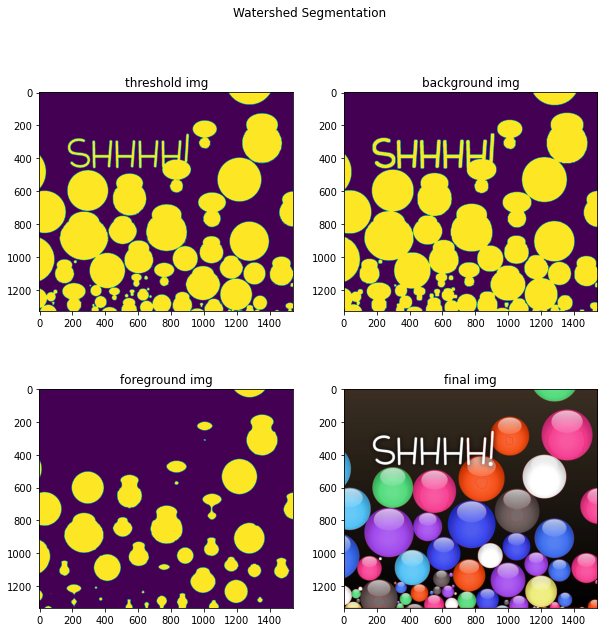

In [19]:
def watershed(imgpath):
    img = cv2.imread(imgpath)
    # 图像转换为灰度值
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    ret0, thresh0 = cv2.threshold(gray,52,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    # 形态学操作   获取结构元素  开操作
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh0,cv2.MORPH_OPEN,kernel, iterations = 2)

    # 确定背景区域
    sure_bg = cv2.dilate(opening,kernel,iterations=3)

    # 确定前景区域
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5) # 计算图像中离0最近的像素点距离
    ret1, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0) # 阈值计算

    # 查找未知区域
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    # 标记标签
    ret2, markers1 = cv2.connectedComponents(sure_fg) # 
    # +1 操作使得背景变为0
    markers = markers1+1
    markers[unknown==255] = 0
    # 分水岭算法，标签图像被修改(边界区域被标记为 -1)
    markers3 = cv2.watershed(img,markers)
    img[markers3 == -1] = [255,0,0]
    return thresh0,sure_bg,sure_fg,img

def draw_image(rows,cols,img,title):
    plt.figure(figsize=(10,10))
    plt.suptitle('Watershed Segmentation')
    
    for i in range(rows*cols):
        plt.subplot(rows,cols,i+1)
        plt.title(title[i])
        plt.imshow(img[i])
# [thresh0, sure_bg, sure_fg, img]
img_list = watershed('./ball.jpg')
title_list = ['threshold img','background img','foreground img','final img']
draw_image(2,2,img_list,title_list)   

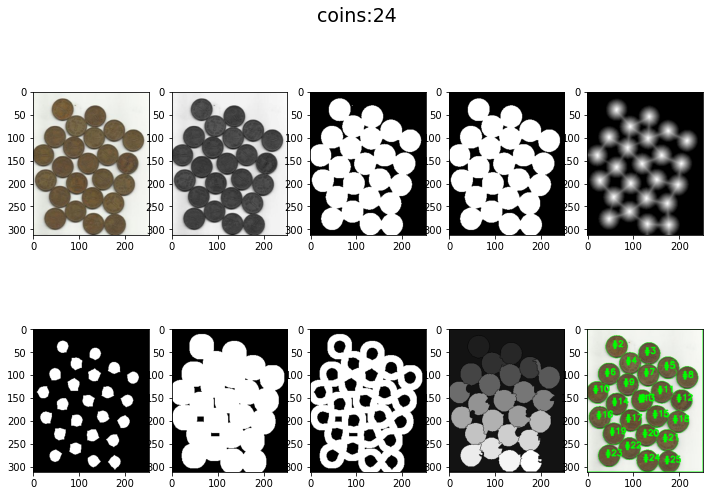

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
# 在区域中写字
def putText(img,labels):
	for label in np.unique(labels):
		# if the label is zero, we are examining the 'background'
		# so simply ignore it
		if label == 0:
			continue
		# otherwise, allocate memory for the label region and draw
		# it on the mask
		mask = np.zeros(img_gray.shape, dtype="uint8")
		mask[labels == label] = 255
		# detect contours in the mask and grab the largest one
		cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
			cv2.CHAIN_APPROX_SIMPLE)
		cnts = imutils.grab_contours(cnts)
		c = max(cnts, key=cv2.contourArea)

		# draw a circle enclosing the object
		((x, y), r) = cv2.minEnclosingCircle(c)
		# 画圆
		#cv2.circle(img, (int(x), int(y)), int(r), (0, 255, 0), 2)
		# 写字
		cv2.putText(img, "#{}".format(label), (int(x) - 10, int(y)),
			cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
	return img

def draw_img(rows,cols,img_list,title):
    plt.figure(figsize=(12,8))
    plt.suptitle(title,fontsize='19')
    for i in range(len(img_list)):
        plt.subplot(rows,cols,i+1)
        if( i==0 | i== len(img_list)):
            plt.imshow(img_list[i])
            
        else:
            plt.imshow(img_list[i],cmap='gray')
###################################

img = cv2.imread('3.png') #img.shape返回：(312, 252, 3)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #img_gray.shape返回：(312, 252)

#------------Otsu阈值处理,变成二值图像--------------
t, otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)   #t返回162.0， otsu.shape返回(312, 252)

#------------形态学的开运算，就是先腐蚀erode后膨胀dilate,目的一是去噪，二是先把前景对象重叠的部分分开，方便后面计数或者画每个对象的轮廓-------------
img_opening = cv2.morphologyEx(otsu, cv2.MORPH_OPEN, kernel=np.ones((3,3), np.uint8), iterations=2)  #A 这还是一个二值图像

#-------计算距离,确定前景对象--------------------
dist = cv2.distanceTransform(img_opening, cv2.DIST_L2, 5)   #float32的浮点型数组，dist.shape返回(312, 252),dist是一个灰度图像
th, sure_fg = cv2.threshold(dist, 0.5*dist.max(), 255, cv2.THRESH_BINARY) #把dist阈值化处理，变成一个0和255的二值图像，此时就是我们要的确定前景
sure_fg = np.uint8(sure_fg)

#-----计算确定背景、计算未知区域------------------
sure_bg = cv2.dilate(img_opening, kernel=np.ones((3,3), np.uint8), iterations=3) #对前景膨胀来确定背景
unknown = cv2.subtract(sure_bg, sure_fg)  #确定背景图-确定前景图，生成未知区域图

#------标注确定前景图,调整标注规则---------------------------
ret, labels = cv2.connectedComponents(sure_fg)  #有24个硬币，ret返回是25, labels是一个形状是(312, 252)的int32的数组
labels = labels+1  #把背景标为1，前景对象依次为2，3，，，26
labels[unknown==255]=0  #0代表未知区域
img1 = img.copy()
img1 = putText(img1,labels)
#------------使用分水岭算法对图像进行分割---------------

markers = cv2.watershed(img1,labels)
img1[markers==-1]=[0,255,0]

img_list =[img[:,:,::-1],img_gray, otsu,img_opening,dist, 
           sure_fg,sure_bg, unknown, labels,img1[:,:,::-1]]
draw_img(2,5,img_list,title='coins:{}'.format(ret-1))
